## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Text(0.5,1,'Undistorted Image')

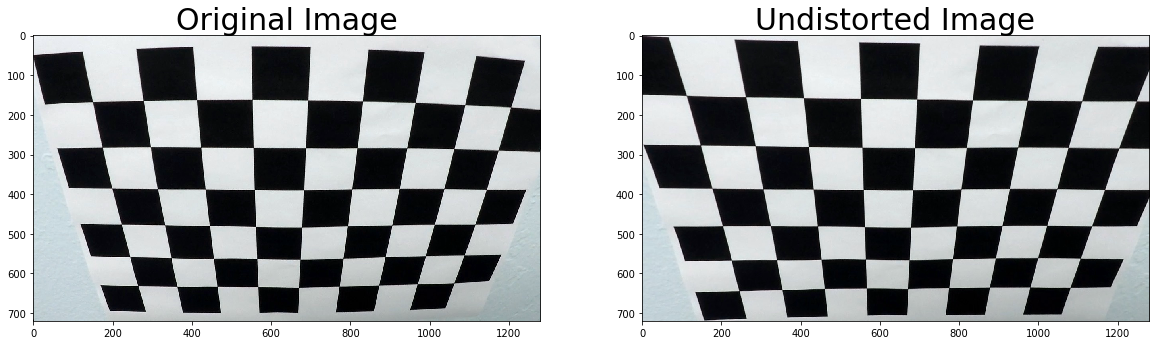

In [3]:
# Camera calibration
# chessboard size
nx = 9
ny = 6
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        #cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        #write_name = 'camera_cal_output/'+'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration2.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration give object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [ ]:
# Save the camera calibration result for later use
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )

In [4]:
# Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load( open( "wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

## Define functions that get undistort image, binary image, perspective transformed image, and warped image. Find lane line pixels, fit line curves, and draw back to the image.

In [5]:
# Undistort image
def undistort_image(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# Get binary image
def create_binary(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    #combined thresholds
    combined = np.zeros_like(s_binary)
    combined[(sxbinary == 1) | (s_binary == 1)] = 1
    #return combined
    return combined

# Perspective transform to an undistorted image
#define src
src = np.float32([[585, 460],
                  [203, 720],
                  [1127, 720],
                  [695, 460]])
#define dst
dst = np.float32([[320, 0],
                  [320, 720],
                  [960, 720],
                  [960, 0]])
Minv = cv2.getPerspectiveTransform(dst, src)
def warper(img, src, dst):
    # Compute and apply perpective transform
    # The img should be an undistorted image
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image
    return warped

def search_around_poly_refit(binary_warped):
    # Declare global variables
    global left_fit_pool, left_fit_avg, right_fit_pool, right_fit_avg
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 100
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### consider the window areas for the similarly named variables ###
    ### in the previous, but change the windows to new search area ###
    left_lane_inds = ((nonzerox >= left_fit_avg[0]*nonzeroy**2+left_fit_avg[1]*nonzeroy+left_fit_avg[2]-margin) & 
    (nonzerox < left_fit_avg[0]*nonzeroy**2+left_fit_avg[1]*nonzeroy+left_fit_avg[2]+margin))
    right_lane_inds = ((nonzerox >= right_fit_avg[0]*nonzeroy**2+right_fit_avg[1]*nonzeroy+right_fit_avg[2]-margin) & 
    (nonzerox < right_fit_avg[0]*nonzeroy**2+right_fit_avg[1]*nonzeroy+right_fit_avg[2]+margin))
    # extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit new polynomials
    left_fit = np.polyfit(x=lefty, y=leftx, deg=2)
    right_fit = np.polyfit(x=righty, y=rightx, deg=2)
    # Check any large deviation and update fitting results
    left_conditions = np.absolute(left_fit-left_fit_avg)/left_fit_avg < 10
    #left_conditions = abs(np.log10(left_fit/left_fit_avg)) < 1.3
    if np.isin(False, left_conditions):
        left_fit = np.copy(left_fit_avg)
    left_fit_pool = update_fit(left_fit_pool, left_fit, holder=7)
    left_fit_avg = np.mean(left_fit_pool, axis=0)
    right_conditions = np.absolute(right_fit-right_fit_avg)/right_fit_avg < 10
    if np.isin(False, right_conditions):
        right_fit = np.copy(right_fit_avg)
    right_fit_pool = update_fit(right_fit_pool, right_fit, holder=7)
    right_fit_avg = np.mean(right_fit_pool, axis=0)
    #Generate x and y values for plotting
    img_shape = binary_warped.shape
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ###  Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    #return
    return left_fitx, right_fitx, ploty, left_fit, right_fit, leftx, rightx
    
def color_lane_region(undist, binary_warped, left_fitx, right_fitx, ploty, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (binary_warped.shape[1], binary_warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

In [6]:
# Initiate polynomial fit values 
left_fit_pool = np.array([[ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02]])
right_fit_pool = np.array([[4.17622148e-04, -4.93848953e-01,  1.11806170e+03]])

# Average fitting results
left_fit_avg = np.mean(left_fit_pool, axis=0)
right_fit_avg = np.mean(right_fit_pool, axis=0)# Initiate curve radius

# Update fitting results
def update_fit(fit_pool, fit_new, holder=7):
    fit_pool = np.vstack([fit_pool, fit_new])
    if fit_pool.shape[0]>holder:
        fit_pool = np.delete(fit_pool, (0), axis=0)
    return fit_pool

## Define pipeline that processes images

In [7]:
# Define pipeline to process images
def process_image(image):
    #undistort image
    undist_image = undistort_image(image, mtx, dist)
    #get binary image
    binary_image = create_binary(undist_image)
    #perspective transform image
    binary_warped = warper(binary_image, src, dst)
    #fit
    left_fitx, right_fitx, ploty, left_fit, right_fit, leftx, rightx = search_around_poly_refit(binary_warped)
    #draw lane regions
    result = color_lane_region(undist_image, binary_warped, left_fitx, right_fitx, ploty, Minv)
    return result

## Process video

In [8]:
white_output = 'project_video_output.mp4'
clip = VideoFileClip("project_video.mp4")#.subclip(0,30)
white_clip = clip.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [02:37<00:00,  8.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min 38s, sys: 41.7 s, total: 4min 19s
Wall time: 2min 39s


In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))